In [ ]:
!pip install torch seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 64

In [ ]:
cd /content/drive/MyDrive/DL/HW2

/content/drive/MyDrive/DL/HW2


##**Data**

In [ ]:
international_matches = pd.read_csv('./data/international_matches.csv')

In [ ]:
international_matches.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


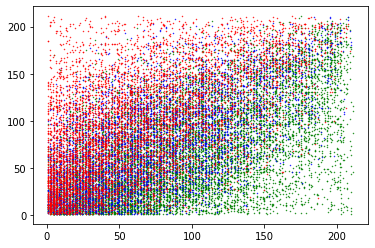

In [ ]:
home_win = international_matches[international_matches['home_team_result'] == 'Win'] 
home_draw = international_matches[international_matches['home_team_result'] == 'Draw'] 
home_lose = international_matches[international_matches['home_team_result'] == 'Lose'] 
plt.scatter(home_win['away_team_fifa_rank'], home_win['home_team_fifa_rank'], c='green', s =0.2)
plt.scatter(home_draw['away_team_fifa_rank'], home_draw['home_team_fifa_rank'], c='blue', s =0.2)
plt.scatter(home_lose['away_team_fifa_rank'], home_lose['home_team_fifa_rank'], c='red', s =0.2)
plt.show()

In [ ]:
filtered_international_matches = international_matches[international_matches['home_team_total_fifa_points']!=0][[
    'away_team_fifa_rank','home_team_fifa_rank','home_team_total_fifa_points','away_team_total_fifa_points', 'home_team_result'
]]

# shuffle the DataFrame rows
filtered_international_matches = filtered_international_matches.sample(frac = 1)
train_size = int(0.75*len(filtered_international_matches))
train_dataframe = filtered_international_matches.iloc[:train_size,:]
test_dataframe = filtered_international_matches.iloc[train_size:,:]

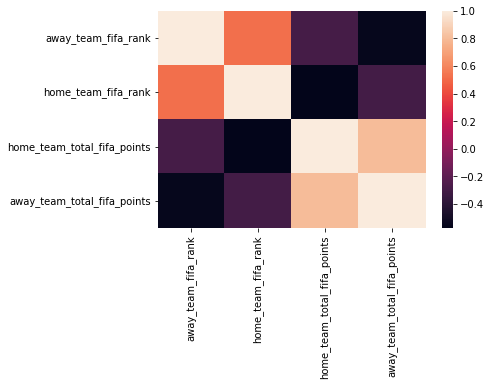

In [ ]:
import seaborn as sns
sns.heatmap(filtered_international_matches.corr())
plt.show()

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
class FootballDataset(Dataset):
 
  def __init__(self,df): 
    x=df.iloc[:,0:4].values
    y=df.iloc[:,4].values
    y[y=='Win'] = 2
    y[y=='Draw'] = 1
    y[y=='Lose'] = 0
    self.x=torch.Inttensor(x,dtype=torch.float32)
    self.y=torch.tensor(y.astype(int),dtype=int)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,i):
    return self.x[i],self.y[i]

In [ ]:
train_dataset = FootballDataset(train_dataframe)
test_dataset = FootballDataset(test_dataframe)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

##**Model**

In [ ]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


class FootballNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(4, 10)
      self.fc2 = nn.Linear(10, 20)
      self.fc3 = nn.Linear(20, 8)
      self.fc4 = nn.Linear(8, 3)

    def forward(self, x):
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.fc3(x)
      x = F.relu(x)
      logits = self.fc4(x)
      return logits


In [ ]:
def calculate_accuracy(logits, labels):
  predictions = torch.argmax(logits, dim=1)
  true = torch.sum(predictions==labels)
  return true

def evaluate(dataloader, model, loss_function):
  eval_loss = 0
  total_true = 0
  for x,y in dataloader:
    with torch.no_grad():
      logits = model(x)
      loss = loss_function(logits, y)
      eval_loss+= loss.item()
      total_true+= calculate_accuracy(logits, y)
  acuuracy = total_true/len(dataloader.dataset)
  print('eval loss ', eval_loss)
  print('eval accuracy ', acuuracy)

In [ ]:
from tqdm import tqdm

football_net = FootballNet()
optimizer = optim.SGD(football_net.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for epoch in range(0,100):
  train_loss =0
  print('-'*10, epoch, '-'*10,'\n')
  for x,y in tqdm(train_loader):
    logits = football_net(x)
    loss = loss_function(logits, y)
    train_loss+= loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('train loss ', train_loss)
  evaluate(test_loader, football_net, loss_function)


---------- 0 ---------- 



100%|██████████| 113/113 [00:00<00:00, 348.46it/s]


train loss  247.0616597533226
eval loss  37.54750722646713
eval accuracy  tensor(0.5378)
---------- 1 ---------- 



100%|██████████| 113/113 [00:00<00:00, 282.53it/s]


train loss  110.71131217479706
eval loss  36.30420708656311
eval accuracy  tensor(0.5644)
---------- 2 ---------- 



100%|██████████| 113/113 [00:00<00:00, 809.32it/s]


train loss  107.90192753076553
eval loss  36.165874898433685
eval accuracy  tensor(0.5727)
---------- 3 ---------- 



100%|██████████| 113/113 [00:00<00:00, 844.94it/s]


train loss  107.97578775882721
eval loss  35.96302330493927
eval accuracy  tensor(0.5752)
---------- 4 ---------- 



100%|██████████| 113/113 [00:00<00:00, 954.93it/s]


train loss  107.28966385126114
eval loss  35.96583145856857
eval accuracy  tensor(0.5743)
---------- 5 ---------- 



100%|██████████| 113/113 [00:00<00:00, 963.08it/s]


train loss  107.06006491184235
eval loss  35.77420610189438
eval accuracy  tensor(0.5818)
---------- 6 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1016.76it/s]


train loss  106.72327882051468
eval loss  35.76198750734329
eval accuracy  tensor(0.5851)
---------- 7 ---------- 



100%|██████████| 113/113 [00:00<00:00, 901.04it/s]


train loss  106.18735408782959
eval loss  35.78653025627136
eval accuracy  tensor(0.5735)
---------- 8 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1043.76it/s]


train loss  106.1293808221817
eval loss  35.8638978600502
eval accuracy  tensor(0.5764)
---------- 9 ---------- 



100%|██████████| 113/113 [00:00<00:00, 925.06it/s]


train loss  105.98003250360489
eval loss  35.70324420928955
eval accuracy  tensor(0.5756)
---------- 10 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1015.11it/s]


train loss  106.17591106891632
eval loss  35.672420620918274
eval accuracy  tensor(0.5822)
---------- 11 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1000.38it/s]


train loss  105.82663077116013
eval loss  35.99771690368652
eval accuracy  tensor(0.5677)
---------- 12 ---------- 



100%|██████████| 113/113 [00:00<00:00, 903.48it/s]


train loss  105.97440153360367
eval loss  35.71927809715271
eval accuracy  tensor(0.5801)
---------- 13 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1018.00it/s]


train loss  105.71912080049515
eval loss  35.516861975193024
eval accuracy  tensor(0.5777)
---------- 14 ---------- 



100%|██████████| 113/113 [00:00<00:00, 848.00it/s]


train loss  105.69622129201889
eval loss  35.57264620065689
eval accuracy  tensor(0.5814)
---------- 15 ---------- 



100%|██████████| 113/113 [00:00<00:00, 999.08it/s] 


train loss  105.68262606859207
eval loss  35.50887131690979
eval accuracy  tensor(0.5789)
---------- 16 ---------- 



100%|██████████| 113/113 [00:00<00:00, 955.69it/s]


train loss  105.77928817272186
eval loss  35.52403795719147
eval accuracy  tensor(0.5814)
---------- 17 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1042.59it/s]


train loss  105.5825366973877
eval loss  35.56542611122131
eval accuracy  tensor(0.5793)
---------- 18 ---------- 



100%|██████████| 113/113 [00:00<00:00, 948.76it/s]


train loss  105.51648497581482
eval loss  35.3826077580452
eval accuracy  tensor(0.5793)
---------- 19 ---------- 



100%|██████████| 113/113 [00:00<00:00, 985.20it/s] 


train loss  105.53782588243484
eval loss  35.388265669345856
eval accuracy  tensor(0.5789)
---------- 20 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1009.18it/s]


train loss  105.44504398107529
eval loss  35.4452731013298
eval accuracy  tensor(0.5793)
---------- 21 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1040.67it/s]


train loss  105.5044059753418
eval loss  35.689656496047974
eval accuracy  tensor(0.5723)
---------- 22 ---------- 



100%|██████████| 113/113 [00:00<00:00, 855.47it/s]


train loss  105.43095844984055
eval loss  35.441911458969116
eval accuracy  tensor(0.5818)
---------- 23 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1003.84it/s]


train loss  105.38924378156662
eval loss  35.38886022567749
eval accuracy  tensor(0.5822)
---------- 24 ---------- 



100%|██████████| 113/113 [00:00<00:00, 995.46it/s] 


train loss  105.2282926440239
eval loss  35.43970054388046
eval accuracy  tensor(0.5818)
---------- 25 ---------- 



100%|██████████| 113/113 [00:00<00:00, 960.33it/s]


train loss  105.43020689487457
eval loss  35.34885984659195
eval accuracy  tensor(0.5818)
---------- 26 ---------- 



100%|██████████| 113/113 [00:00<00:00, 964.56it/s] 


train loss  105.32760310173035
eval loss  35.456285297870636
eval accuracy  tensor(0.5772)
---------- 27 ---------- 



100%|██████████| 113/113 [00:00<00:00, 912.49it/s]


train loss  105.21199589967728
eval loss  35.36407274007797
eval accuracy  tensor(0.5785)
---------- 28 ---------- 



100%|██████████| 113/113 [00:00<00:00, 926.88it/s]


train loss  105.28634136915207
eval loss  35.4643417596817
eval accuracy  tensor(0.5801)
---------- 29 ---------- 



100%|██████████| 113/113 [00:00<00:00, 907.15it/s]


train loss  105.22118055820465
eval loss  35.46433490514755
eval accuracy  tensor(0.5785)
---------- 30 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1005.45it/s]


train loss  105.23907071352005
eval loss  35.46720486879349
eval accuracy  tensor(0.5793)
---------- 31 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1001.38it/s]


train loss  105.11390197277069
eval loss  35.55748641490936
eval accuracy  tensor(0.5801)
---------- 32 ---------- 



100%|██████████| 113/113 [00:00<00:00, 986.18it/s] 


train loss  105.13964956998825
eval loss  35.33070796728134
eval accuracy  tensor(0.5814)
---------- 33 ---------- 



100%|██████████| 113/113 [00:00<00:00, 190.62it/s]


train loss  105.12922459840775
eval loss  35.43802684545517
eval accuracy  tensor(0.5797)
---------- 34 ---------- 



100%|██████████| 113/113 [00:00<00:00, 543.05it/s]


train loss  105.07480931282043
eval loss  35.439424216747284
eval accuracy  tensor(0.5801)
---------- 35 ---------- 



100%|██████████| 113/113 [00:00<00:00, 779.46it/s]


train loss  105.02911061048508
eval loss  35.315163254737854
eval accuracy  tensor(0.5810)
---------- 36 ---------- 



100%|██████████| 113/113 [00:00<00:00, 983.75it/s] 


train loss  104.94888389110565
eval loss  35.33763647079468
eval accuracy  tensor(0.5777)
---------- 37 ---------- 



100%|██████████| 113/113 [00:00<00:00, 561.58it/s]


train loss  105.08191978931427
eval loss  35.257252395153046
eval accuracy  tensor(0.5831)
---------- 38 ---------- 



100%|██████████| 113/113 [00:00<00:00, 186.35it/s]


train loss  104.9605667591095
eval loss  35.288530111312866
eval accuracy  tensor(0.5814)
---------- 39 ---------- 



100%|██████████| 113/113 [00:00<00:00, 760.82it/s]


train loss  105.00581121444702
eval loss  35.34152168035507
eval accuracy  tensor(0.5806)
---------- 40 ---------- 



100%|██████████| 113/113 [00:00<00:00, 965.13it/s] 


train loss  104.89457428455353
eval loss  35.33274203538895
eval accuracy  tensor(0.5793)
---------- 41 ---------- 



100%|██████████| 113/113 [00:00<00:00, 818.26it/s]


train loss  104.98212283849716
eval loss  35.273923099040985
eval accuracy  tensor(0.5814)
---------- 42 ---------- 



100%|██████████| 113/113 [00:00<00:00, 959.45it/s]


train loss  104.91822457313538
eval loss  35.22066932916641
eval accuracy  tensor(0.5814)
---------- 43 ---------- 



100%|██████████| 113/113 [00:00<00:00, 945.22it/s]


train loss  104.80411714315414
eval loss  35.26668852567673
eval accuracy  tensor(0.5806)
---------- 44 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1036.02it/s]


train loss  104.91561079025269
eval loss  35.27562898397446
eval accuracy  tensor(0.5826)
---------- 45 ---------- 



100%|██████████| 113/113 [00:00<00:00, 923.39it/s]


train loss  104.91361451148987
eval loss  35.28566473722458
eval accuracy  tensor(0.5797)
---------- 46 ---------- 



100%|██████████| 113/113 [00:00<00:00, 973.47it/s] 


train loss  104.92505252361298
eval loss  35.23483890295029
eval accuracy  tensor(0.5831)
---------- 47 ---------- 



100%|██████████| 113/113 [00:00<00:00, 977.50it/s] 


train loss  104.81524461507797
eval loss  35.229867696762085
eval accuracy  tensor(0.5822)
---------- 48 ---------- 



100%|██████████| 113/113 [00:00<00:00, 922.18it/s]


train loss  104.87161076068878
eval loss  35.21938335895538
eval accuracy  tensor(0.5822)
---------- 49 ---------- 



100%|██████████| 113/113 [00:00<00:00, 927.14it/s] 


train loss  104.75833147764206
eval loss  35.252609968185425
eval accuracy  tensor(0.5793)
---------- 50 ---------- 



100%|██████████| 113/113 [00:00<00:00, 969.71it/s] 


train loss  104.84135615825653
eval loss  35.236933052539825
eval accuracy  tensor(0.5831)
---------- 51 ---------- 



100%|██████████| 113/113 [00:00<00:00, 941.82it/s]


train loss  104.72036176919937
eval loss  35.281840443611145
eval accuracy  tensor(0.5801)
---------- 52 ---------- 



100%|██████████| 113/113 [00:00<00:00, 964.94it/s] 


train loss  104.72801119089127
eval loss  35.252257347106934
eval accuracy  tensor(0.5822)
---------- 53 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1016.22it/s]


train loss  104.85792762041092
eval loss  35.233759582042694
eval accuracy  tensor(0.5826)
---------- 54 ---------- 



100%|██████████| 113/113 [00:00<00:00, 940.15it/s]


train loss  104.78345322608948
eval loss  35.19377702474594
eval accuracy  tensor(0.5822)
---------- 55 ---------- 



100%|██████████| 113/113 [00:00<00:00, 967.42it/s] 


train loss  104.77593851089478
eval loss  35.252431094646454
eval accuracy  tensor(0.5806)
---------- 56 ---------- 



100%|██████████| 113/113 [00:00<00:00, 890.64it/s]


train loss  104.76973569393158
eval loss  35.224362313747406
eval accuracy  tensor(0.5810)
---------- 57 ---------- 



100%|██████████| 113/113 [00:00<00:00, 984.53it/s] 


train loss  104.79409843683243
eval loss  35.25249922275543
eval accuracy  tensor(0.5810)
---------- 58 ---------- 



100%|██████████| 113/113 [00:00<00:00, 983.49it/s] 


train loss  104.68667387962341
eval loss  35.11759573221207
eval accuracy  tensor(0.5810)
---------- 59 ---------- 



100%|██████████| 113/113 [00:00<00:00, 933.89it/s]


train loss  104.75849413871765
eval loss  35.20671421289444
eval accuracy  tensor(0.5826)
---------- 60 ---------- 



100%|██████████| 113/113 [00:00<00:00, 996.19it/s] 


train loss  104.69887632131577
eval loss  35.26767134666443
eval accuracy  tensor(0.5797)
---------- 61 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1012.45it/s]


train loss  104.69424784183502
eval loss  35.20140761137009
eval accuracy  tensor(0.5831)
---------- 62 ---------- 



100%|██████████| 113/113 [00:00<00:00, 903.71it/s]


train loss  104.69634801149368
eval loss  35.15468096733093
eval accuracy  tensor(0.5810)
---------- 63 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1006.00it/s]


train loss  104.81831914186478
eval loss  35.26506298780441
eval accuracy  tensor(0.5810)
---------- 64 ---------- 



100%|██████████| 113/113 [00:00<00:00, 947.05it/s]


train loss  104.73385578393936
eval loss  35.1765142083168
eval accuracy  tensor(0.5818)
---------- 65 ---------- 



100%|██████████| 113/113 [00:00<00:00, 976.80it/s] 


train loss  104.66206902265549
eval loss  35.190724551677704
eval accuracy  tensor(0.5826)
---------- 66 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1005.70it/s]


train loss  104.64616709947586
eval loss  35.195090651512146
eval accuracy  tensor(0.5814)
---------- 67 ---------- 



100%|██████████| 113/113 [00:00<00:00, 977.22it/s] 


train loss  104.71265125274658
eval loss  35.210291504859924
eval accuracy  tensor(0.5810)
---------- 68 ---------- 



100%|██████████| 113/113 [00:00<00:00, 884.66it/s]


train loss  104.67989158630371
eval loss  35.16486084461212
eval accuracy  tensor(0.5818)
---------- 69 ---------- 



100%|██████████| 113/113 [00:00<00:00, 895.77it/s]


train loss  104.71404498815536
eval loss  35.25628983974457
eval accuracy  tensor(0.5801)
---------- 70 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1031.77it/s]


train loss  104.66711050271988
eval loss  35.16731131076813
eval accuracy  tensor(0.5818)
---------- 71 ---------- 



100%|██████████| 113/113 [00:00<00:00, 983.36it/s] 


train loss  104.69370949268341
eval loss  35.13983374834061
eval accuracy  tensor(0.5818)
---------- 72 ---------- 



100%|██████████| 113/113 [00:00<00:00, 939.30it/s]


train loss  104.74587541818619
eval loss  35.207055509090424
eval accuracy  tensor(0.5814)
---------- 73 ---------- 



100%|██████████| 113/113 [00:00<00:00, 967.59it/s] 


train loss  104.69479495286942
eval loss  35.2817063331604
eval accuracy  tensor(0.5785)
---------- 74 ---------- 



100%|██████████| 113/113 [00:00<00:00, 862.34it/s]


train loss  104.70412796735764
eval loss  35.17980068922043
eval accuracy  tensor(0.5826)
---------- 75 ---------- 



100%|██████████| 113/113 [00:00<00:00, 909.06it/s]


train loss  104.6663801074028
eval loss  35.25558805465698
eval accuracy  tensor(0.5806)
---------- 76 ---------- 



100%|██████████| 113/113 [00:00<00:00, 990.25it/s] 


train loss  104.69694101810455
eval loss  35.145392656326294
eval accuracy  tensor(0.5810)
---------- 77 ---------- 



100%|██████████| 113/113 [00:00<00:00, 955.30it/s] 


train loss  104.5997262597084
eval loss  35.32271856069565
eval accuracy  tensor(0.5768)
---------- 78 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1008.20it/s]


train loss  104.66285210847855
eval loss  35.13506007194519
eval accuracy  tensor(0.5814)
---------- 79 ---------- 



100%|██████████| 113/113 [00:00<00:00, 980.97it/s] 


train loss  104.605129301548
eval loss  35.22713512182236
eval accuracy  tensor(0.5810)
---------- 80 ---------- 



100%|██████████| 113/113 [00:00<00:00, 900.83it/s]


train loss  104.68230068683624
eval loss  35.164954125881195
eval accuracy  tensor(0.5822)
---------- 81 ---------- 



100%|██████████| 113/113 [00:00<00:00, 968.96it/s] 


train loss  104.571457862854
eval loss  35.19730430841446
eval accuracy  tensor(0.5806)
---------- 82 ---------- 



100%|██████████| 113/113 [00:00<00:00, 929.37it/s]


train loss  104.59144103527069
eval loss  35.17969900369644
eval accuracy  tensor(0.5806)
---------- 83 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1033.83it/s]


train loss  104.65734404325485
eval loss  35.13211041688919
eval accuracy  tensor(0.5806)
---------- 84 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1010.75it/s]


train loss  104.6141009926796
eval loss  35.13684505224228
eval accuracy  tensor(0.5806)
---------- 85 ---------- 



100%|██████████| 113/113 [00:00<00:00, 819.88it/s]


train loss  104.63893741369247
eval loss  35.213789999485016
eval accuracy  tensor(0.5797)
---------- 86 ---------- 



100%|██████████| 113/113 [00:00<00:00, 955.50it/s] 


train loss  104.62609833478928
eval loss  35.16573393344879
eval accuracy  tensor(0.5822)
---------- 87 ---------- 



100%|██████████| 113/113 [00:00<00:00, 1021.05it/s]


train loss  104.5826952457428
eval loss  35.13201403617859
eval accuracy  tensor(0.5801)
---------- 88 ---------- 



100%|██████████| 113/113 [00:00<00:00, 878.91it/s]


train loss  104.62444323301315
eval loss  35.13570821285248
eval accuracy  tensor(0.5814)
---------- 89 ---------- 



100%|██████████| 113/113 [00:00<00:00, 928.87it/s]


train loss  104.64489209651947
eval loss  35.15258049964905
eval accuracy  tensor(0.5822)
---------- 90 ---------- 



100%|██████████| 113/113 [00:00<00:00, 987.72it/s] 


train loss  104.60821408033371
eval loss  35.26095199584961
eval accuracy  tensor(0.5793)
---------- 91 ---------- 



100%|██████████| 113/113 [00:00<00:00, 920.91it/s]


train loss  104.62924879789352
eval loss  35.15225213766098
eval accuracy  tensor(0.5793)
---------- 92 ---------- 



100%|██████████| 113/113 [00:00<00:00, 855.98it/s]


train loss  104.45442819595337
eval loss  35.284543633461
eval accuracy  tensor(0.5793)
---------- 93 ---------- 



100%|██████████| 113/113 [00:00<00:00, 961.01it/s] 


train loss  104.6256560087204
eval loss  35.24060809612274
eval accuracy  tensor(0.5793)
---------- 94 ---------- 



100%|██████████| 113/113 [00:00<00:00, 896.77it/s] 


train loss  104.47864097356796
eval loss  35.18954008817673
eval accuracy  tensor(0.5793)
---------- 95 ---------- 



100%|██████████| 113/113 [00:00<00:00, 906.04it/s]


train loss  104.54037618637085
eval loss  35.200460612773895
eval accuracy  tensor(0.5806)
---------- 96 ---------- 



100%|██████████| 113/113 [00:00<00:00, 946.69it/s]


train loss  104.58579629659653
eval loss  35.122724413871765
eval accuracy  tensor(0.5826)
---------- 97 ---------- 



100%|██████████| 113/113 [00:00<00:00, 983.95it/s] 


train loss  104.53177416324615
eval loss  35.140550434589386
eval accuracy  tensor(0.5831)
---------- 98 ---------- 



100%|██████████| 113/113 [00:00<00:00, 869.01it/s]


train loss  104.6169513463974
eval loss  35.174098908901215
eval accuracy  tensor(0.5822)
---------- 99 ---------- 



100%|██████████| 113/113 [00:00<00:00, 926.32it/s] 


train loss  104.5663600564003
eval loss  35.18769717216492
eval accuracy  tensor(0.5822)


In [ ]:
'away_team_fifa_rank','home_team_fifa_rank','home_team_total_fifa_points','away_team_total_fifa_points'
iran_wales = torch.tensor([19, 20,	1564.61, 1569.82])
iran_usa = torch.tensor([16, 20,	1564.61, 1627.48])
iran_uk = torch.tensor([5, 20,	1564.61, 1728.47])
i_w_logits = football_net(iran_wales)
print(i_w_logits)
i_w_predictions = torch.argmax(i_w_logits)
print('Iran - Wales',i_w_predictions)

i_us_logits = football_net(iran_usa)
print(i_us_logits)
i_us_predictions = torch.argmax(i_us_logits)
print('Iran - USA',i_us_predictions)

i_uk_logits = football_net(iran_uk)
i_uk_predictions = torch.argmax(i_uk_logits)
print('Iran - UK',i_uk_predictions)

tensor([-0.4867, -0.6004, -0.2913], grad_fn=<AddBackward0>)
Iran - Wales tensor(2)
tensor([-0.5530, -0.8271, -0.6806], grad_fn=<AddBackward0>)
Iran - USA tensor(0)
Iran - UK tensor(0)
